In [2]:
path = 'data/GrowthProfilerResults_Long_Pretest.csv'

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
# REad in long format dataframe (check function plot_growth_cruves for args)

df=pd.read_csv(path)

# remove D6 a none control that luckily doesn't overlap with other conditions as we onluse used a subset of wells
df = df[df['WellID'] != 'D6']


In [53]:
# Let's create a subset where every condition and media only has 3 reps

# This allows for tests that assume even variance (which is not necessarily what happens here just because we line up 3 reps per cond)
df_3reps = df[df['Replicate']<=3].copy()

In [95]:
# Count unique replicates per Media and Condition
# Useful check considering you might want to manipulate replicates/outliers or when some experiments/runs fail.
df.groupby(['Condition', 'Media'])['Replicate'].nunique()

Condition    Media  
OD24_Manual  Media_1    3
             Media_2    3
             Media_3    3
             Media_4    3
OD24_Robot   Media_1    3
             Media_2    5
             Media_3    3
             Media_4    3
OD96_Manual  Media_1    9
             Media_2    9
             Media_3    9
             Media_4    9
OD96_Robot   Media_1    3
             Media_2    5
             Media_3    3
             Media_4    3
Name: Replicate, dtype: int64

In [ ]:
def plot_growth_curves (df, x='Time', y='OD600', hue='Media', style='Condition', ci_level=95):

    """
    Plots growth curves with confidence intervals using seaborn.

    Parameters:
    - df: pandas DataFrame containing the data
    - x: column name for x-axis (default 'Time')
    - y: column name for y-axis (default 'OD600')
    - hue: column name for grouping by color (default 'Media')
    - style: column name for line style (default 'Condition')
    - ci_level: confidence interval level (default 95)
    """

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x=x, y=y, hue=hue, style=style, errorbar =('ci', ci_level))
    plt.title(f'Growth curves by {hue} and {style} - CI({ci_level})')
    plt.ylabel(y)
    plt.xlabel(f'{x} (hours)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_growth_facets(
    df, 
    condition_filter=None,
    x='Time', 
    y='OD600', 
    col='Media', 
    hue='Condition', 
    style='Replicate', 
    ci_level=95,    # Confidence interval level, e.g. 95
    col_wrap=None,  
    height=4, 
    aspect=1.5
):
    """
    Faceted growth curve plots for easy condition/media comparison.

    Parameters:
    - df: pandas DataFrame (long format)
    - condition_filter: list or None, subset of conditions to plot
    - x, y: column names for axes
    - col: column name to facet by (default 'Media')
    - hue: grouping color variable (default 'Condition')
    - style: line style variable (default 'Replicate')
    - ci_level: confidence interval level (default 95)
    - col_wrap: int or None; how many columns before wrapping facets
    - height, aspect: size of each facet
    
    Usage:
    plot_growth_facets(df, condition_filter=['OD24_Manual', 'OD24_Robot'], col_wrap=2)
    """
    if condition_filter is not None:
        df = df[df[hue].isin(condition_filter)]
    
    g = sns.FacetGrid(
        df,
        col=col,
        hue=hue,
        height=height,
        aspect=aspect,
        col_wrap=col_wrap,
        sharey=True
    )
    
    g.map_dataframe(
        sns.lineplot,
        x=x,
        y=y,
        style=style,
        units=style,
        estimator=None,
        errorbar=('ci', ci_level)  # use errorbar param to pass confidence interval level
    )
    
    g.add_legend(title=hue)
    g.set_axis_labels(f"{x} (hours)", y)
    plt.tight_layout()
    plt.show()


In [101]:
def plot_growth_facets(df, condition_filter=None, col_wrap=2, ci_level='sd'):
    """
    Plots facet grid of growth curves across media, grouped by condition.

    Parameters:
    - df: DataFrame in long format
    - condition_filter: list of conditions to include
    - col_wrap: number of columns in FacetGrid layout
    - ci_level: confidence interval or 'sd' for standard deviation shading
    """
    subset = df.copy()
    
    if condition_filter is not None:
        subset = subset[subset['Condition'].isin(condition_filter)]

    g = sns.FacetGrid(
        data=subset,
        col='Media',
        hue='Condition',
        height=4,
        aspect=1.5,
        sharey=True,
        col_wrap=col_wrap
    )

    g.map_dataframe(
        sns.lineplot,
        x='Time',
        y='OD600',
        estimator='mean',
        errorbar=ci_level
    )

    g.add_legend(title='Condition')
    g.set_axis_labels("Time (hours)", "OD600")
    g.set_titles(col_template="{col_name}")
    g.fig.suptitle("Growth Comparison Across Media", fontsize=16, y=1.05)

    plt.tight_layout()
    plt.show()


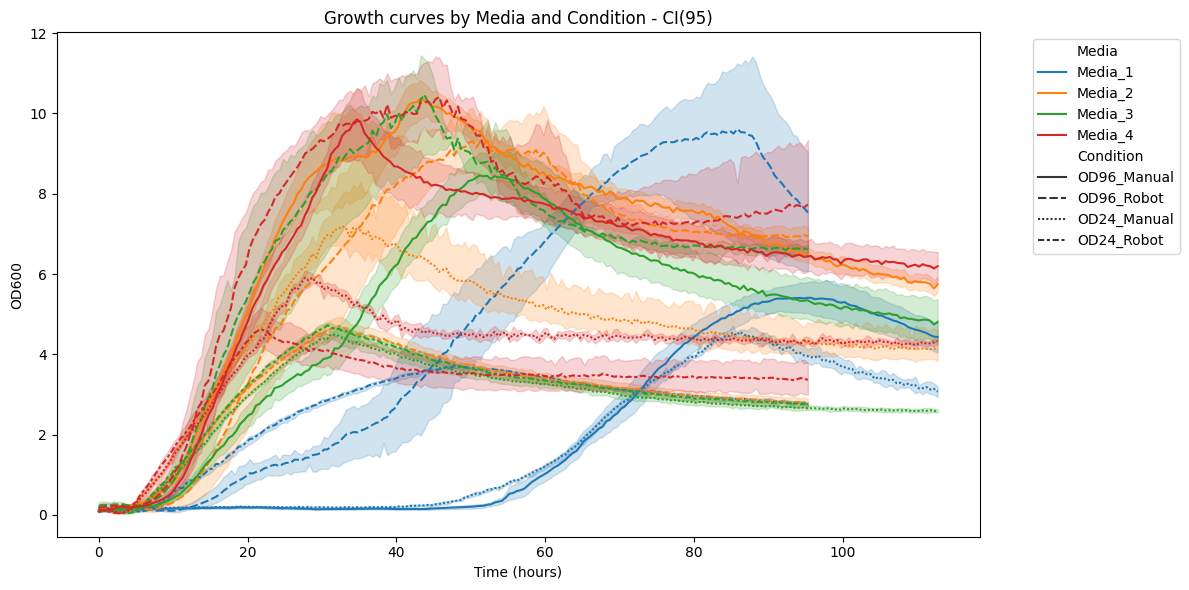

In [48]:
plot_growth_curves(df)

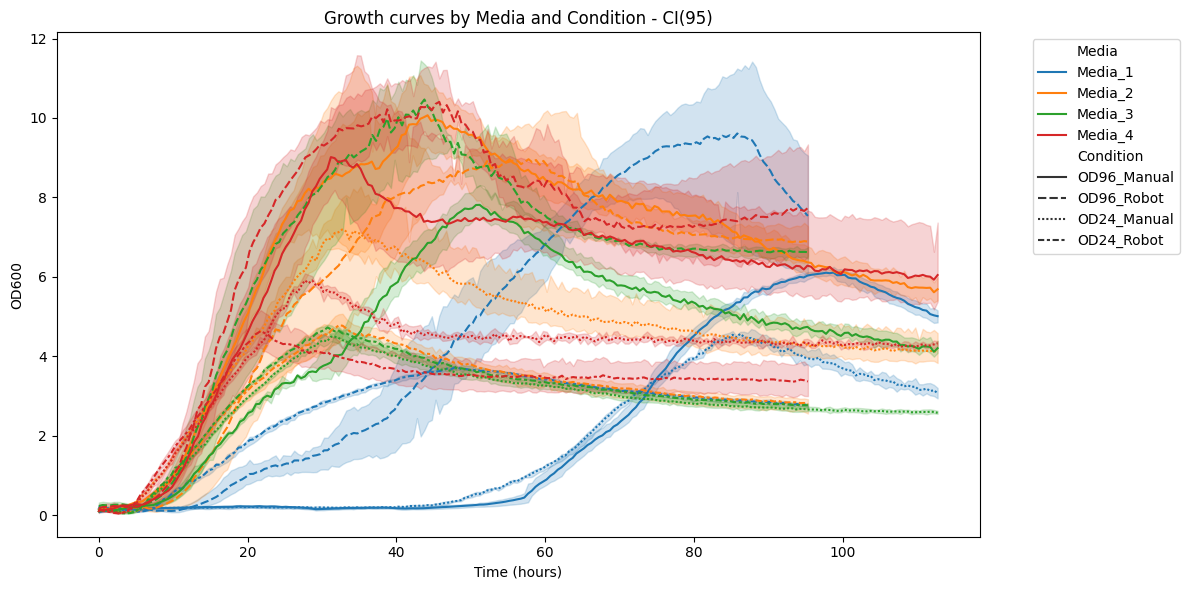

In [55]:
plot_growth_curves(df_3reps)

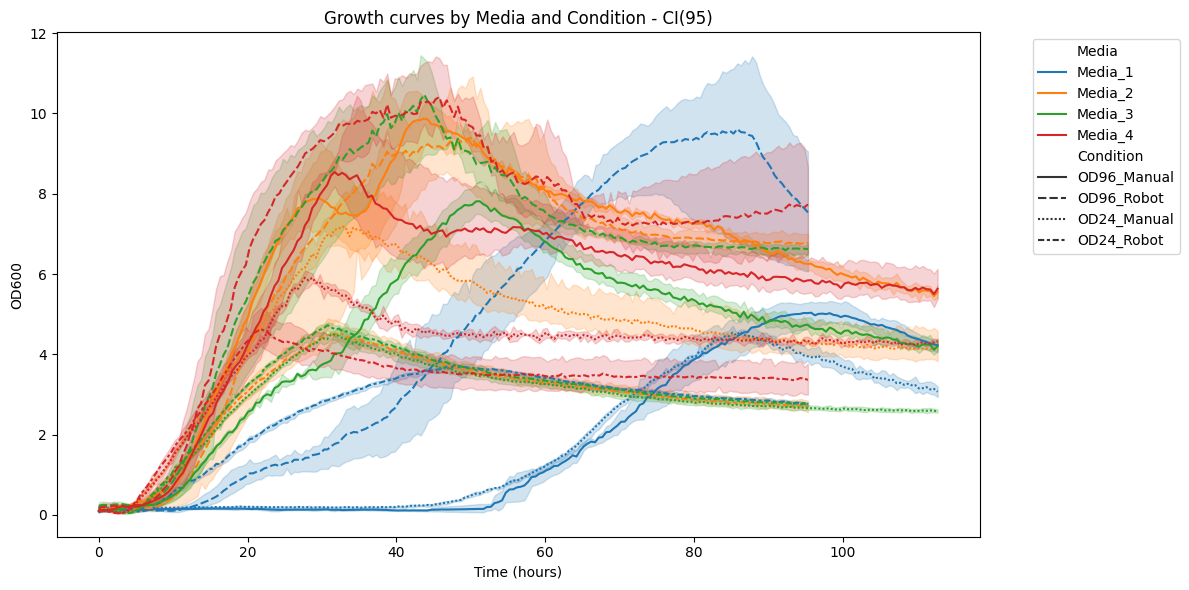

In [81]:
# Step 1: Compute replicate SDs
replicate_sds = (
    df.groupby(['Condition', 'Media', 'Replicate'])['OD600']
    .std()
    .reset_index(name='Replicate_SD')
)

# Step 2: Count replicates per Condition × Media
rep_counts = (
    replicate_sds.groupby(['Condition', 'Media'])['Replicate']
    .count()
    .reset_index(name='Replicate_Count')
)

# Step 3: Merge SDs and replicate counts
replicate_sds = replicate_sds.merge(rep_counts, on=['Condition', 'Media'])

# Step 4: Mark which replicates to keep (top 3 if more than 3, else all)
replicate_sds['Keep'] = (
    replicate_sds
    .sort_values(['Condition', 'Media', 'Replicate_SD'])
    .groupby(['Condition', 'Media'])
    .cumcount() < 3
)

# Keep all if total replicates ≤ 3
replicate_sds['Keep'] = replicate_sds.apply(
    lambda row: True if row['Replicate_Count'] <= 3 else row['Keep'],
    axis=1
)

# Step 5: Filter original df using selected replicates
reps_to_keep = replicate_sds[replicate_sds['Keep']][['Condition', 'Media', 'Replicate']]
df_3reps_low_sd = df.merge(reps_to_keep, on=['Condition', 'Media', 'Replicate']).copy()


plot_growth_curves(df_3reps_low_sd)

In [66]:
df_3reps_low_sd.head()


WellID  OD600      Time    Media  Replicate    Condition
0     B2  0.127  0.000000  Media_1          5  OD96_Manual
1     B2  0.135  0.087500  Media_1          5  OD96_Manual
2     B2  0.148  0.820833  Media_1          5  OD96_Manual
3     B2  0.148  1.325000  Media_1          5  OD96_Manual
4     B2  0.148  1.820833  Media_1          5  OD96_Manual

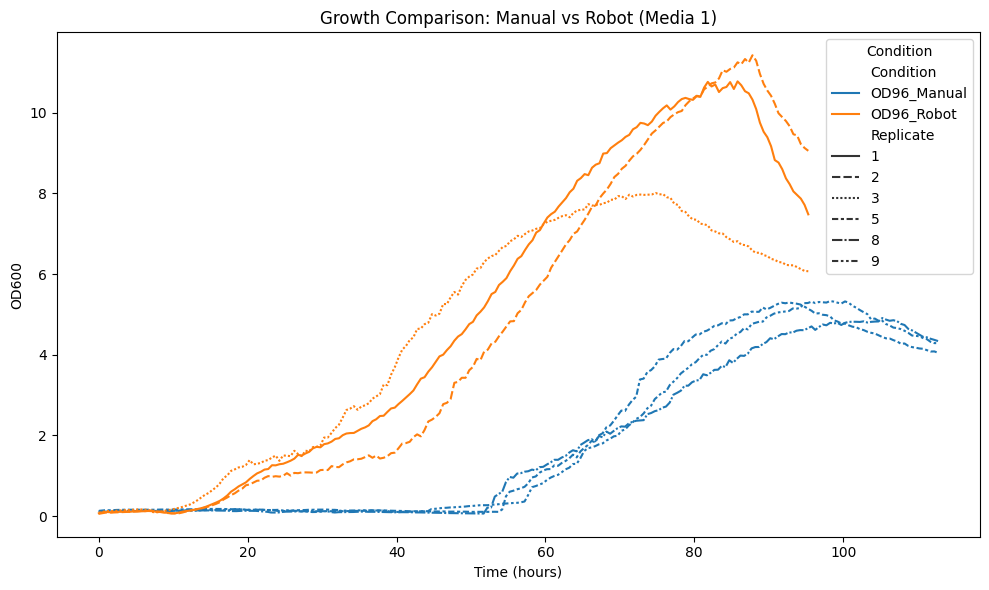

In [78]:
subset = df_3reps_low_sd[
    (df_3reps_low_sd['Condition'].isin(['OD96_Manual', 'OD96_Robot'])) &
    (df_3reps_low_sd['Media'] == 'Media_1')
]
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=subset,
    x='Time',
    y='OD600',
    hue='Condition',
    style='Replicate',
    markers=False,
    dashes=True,
    estimator=None,  # Keep all replicate lines
    units='Replicate'
)

plt.title('Growth Comparison: Manual vs Robot (Media 1)')
plt.ylabel('OD600')
plt.xlabel('Time (hours)')
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

In [84]:
df_3reps_low_sd.head()

WellID  OD600      Time    Media  Replicate    Condition
0     B2  0.127  0.000000  Media_1          5  OD96_Manual
1     B2  0.135  0.087500  Media_1          5  OD96_Manual
2     B2  0.148  0.820833  Media_1          5  OD96_Manual
3     B2  0.148  1.325000  Media_1          5  OD96_Manual
4     B2  0.148  1.820833  Media_1          5  OD96_Manual

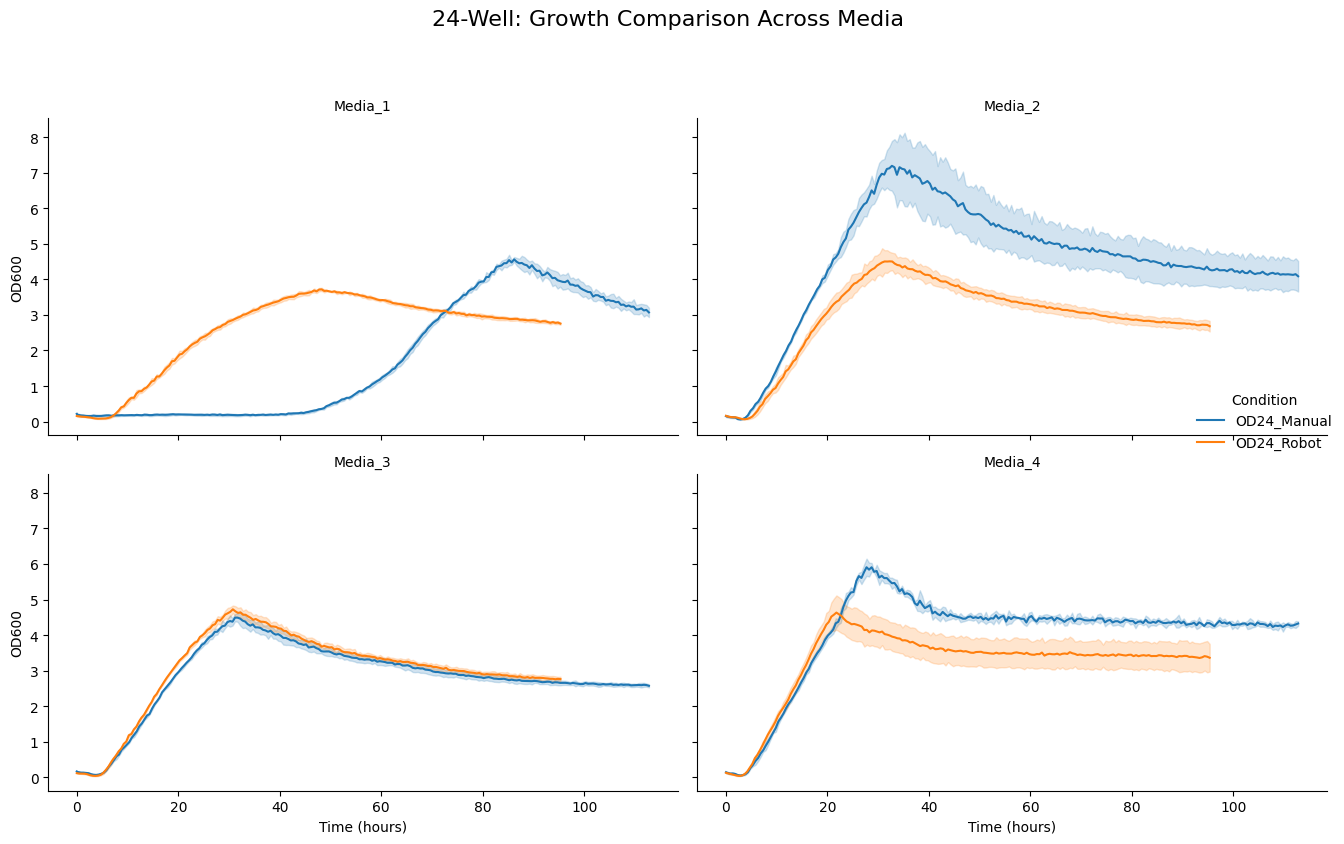

In [88]:
# Filter only the 24-well conditions
subset_24 = df_3reps_low_sd[df_3reps_low_sd['Condition'].isin(['OD24_Manual', 'OD24_Robot'])]

# Set up FacetGrid: one subplot per media
g = sns.FacetGrid(
    data=subset_24,
    col='Media',
    hue='Condition',
    height=4,
    aspect=1.5,
    sharey=True,
    col_wrap=2
)

# Map mean curves with SD shading
g.map_dataframe(
    sns.lineplot,
    x='Time',
    y='OD600',
    estimator='mean',
    errorbar='sd'  # Standard deviation shading
)

# Add legend and labels
g.add_legend(title='Condition')
g.set_axis_labels("Time (hours)", "OD600")
g.set_titles(col_template="{col_name}")
g.fig.suptitle("24-Well: Growth Comparison Across Media", fontsize=16, y=1.05)

plt.tight_layout()
plt.show()

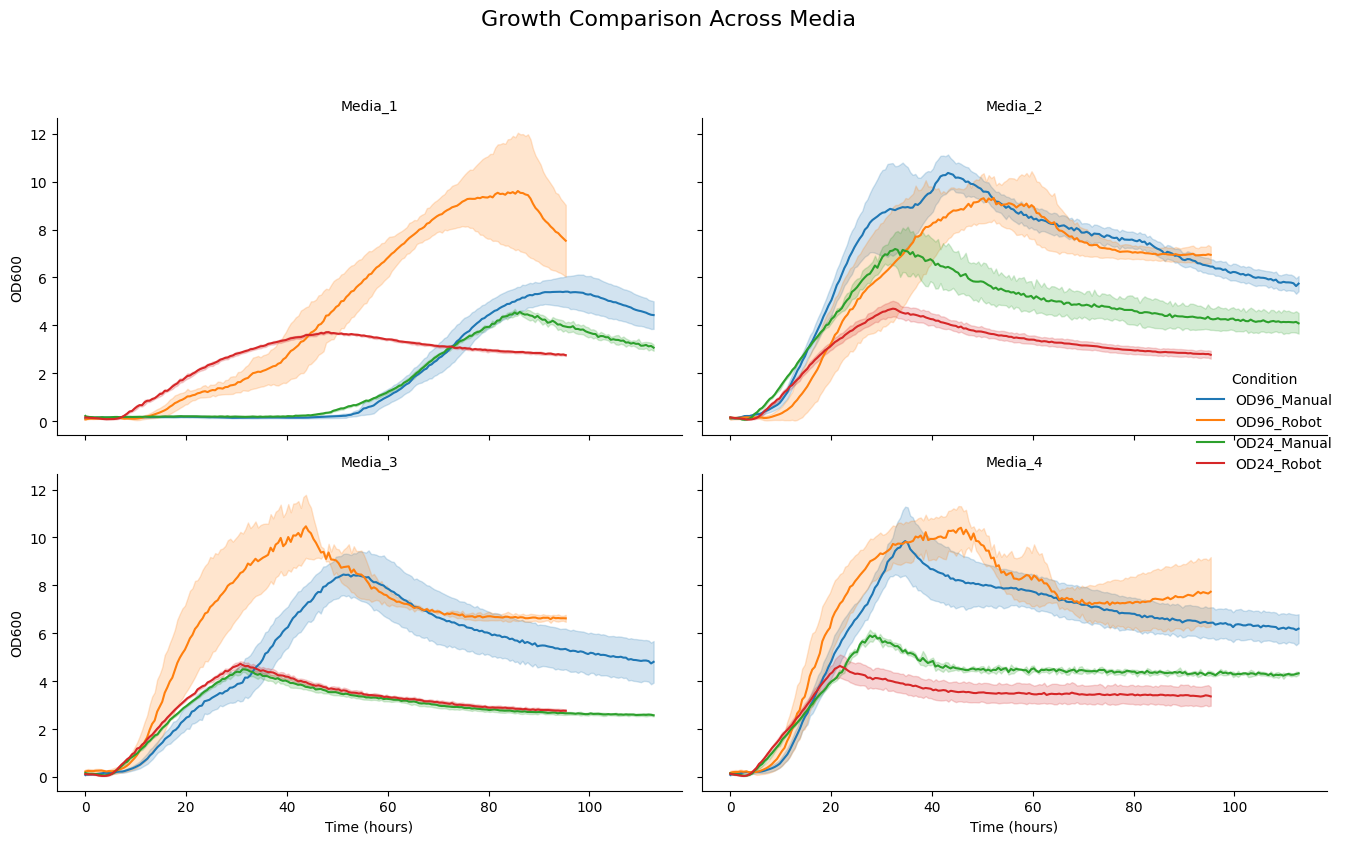

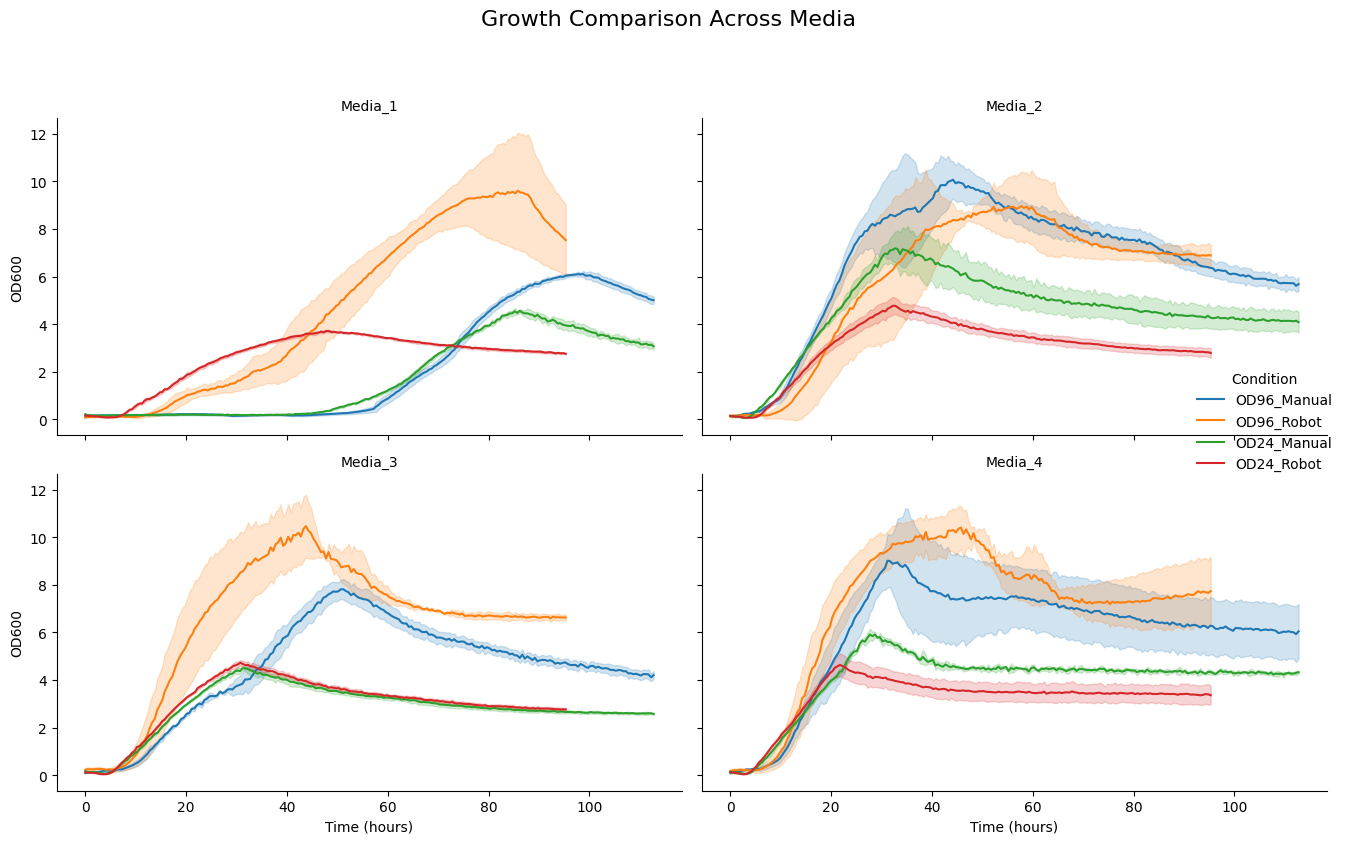

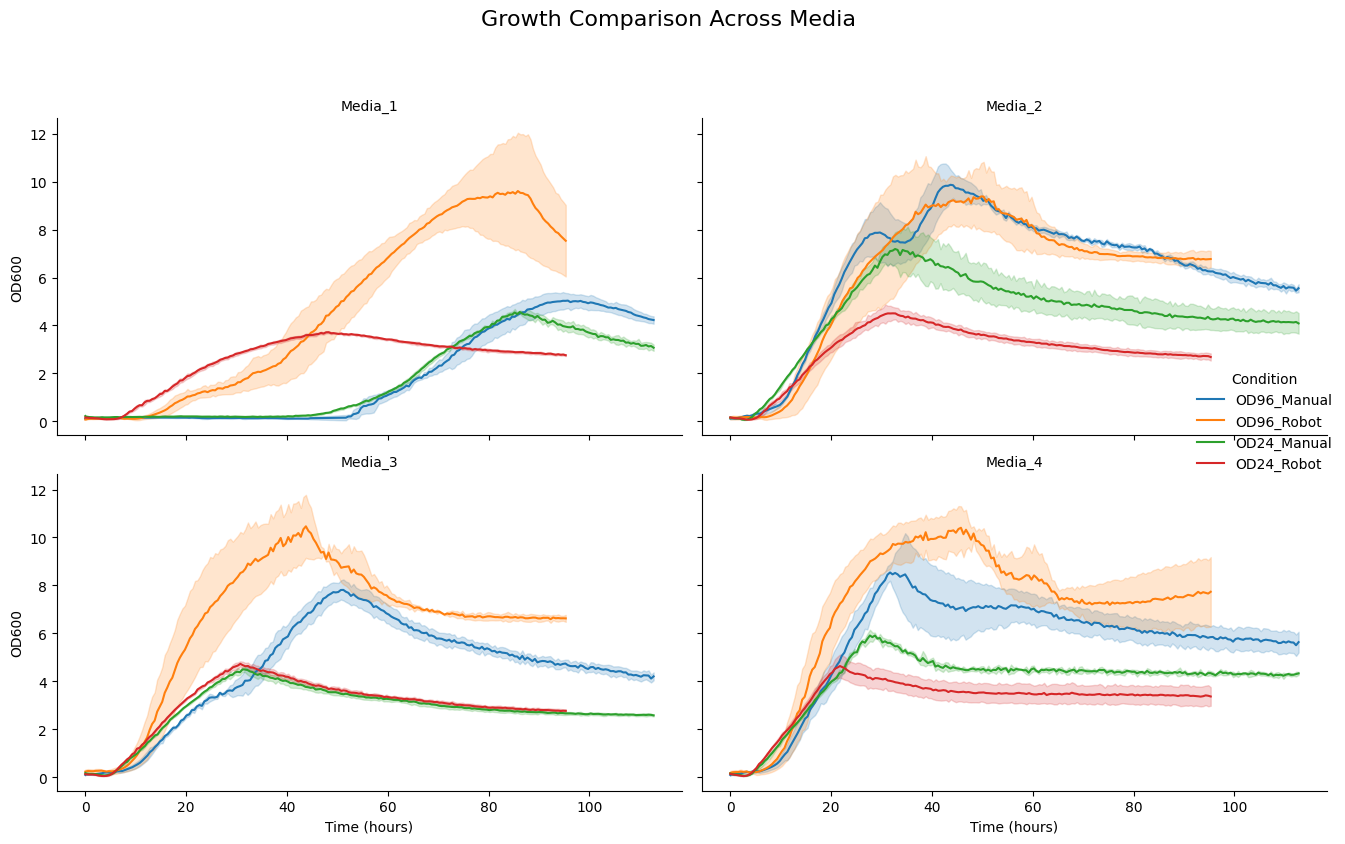

In [114]:
plot_growth_facets(df, condition_filter=['OD24_Manual', 'OD24_Robot', 'OD96_Manual', 'OD96_Robot'])
plot_growth_facets(df_3reps, condition_filter=['OD24_Manual','OD24_Robot','OD96_Manual', 'OD96_Robot'])
plot_growth_facets(df_3reps_low_sd, condition_filter=['OD24_Manual', 'OD24_Robot','OD96_Manual', 'OD96_Robot'])

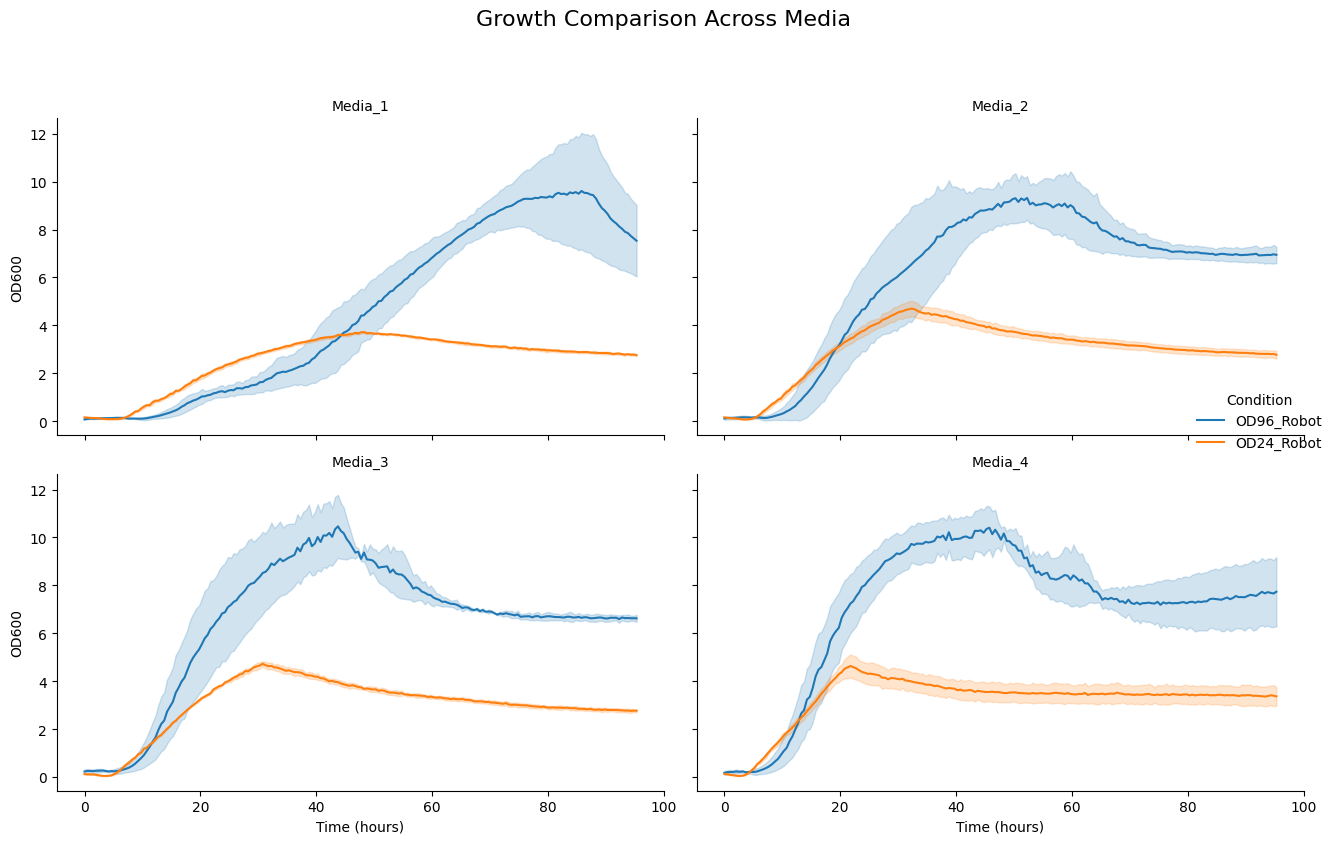

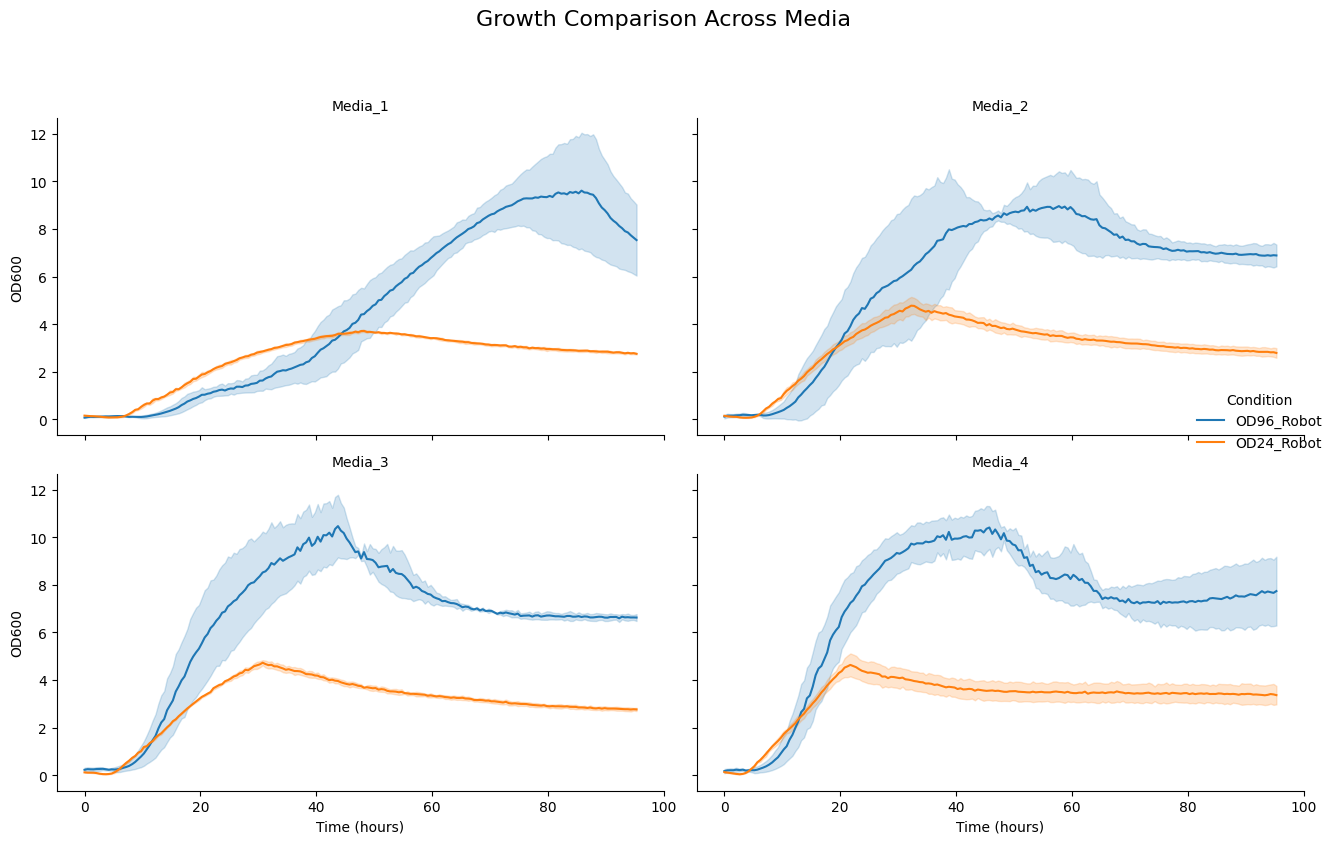

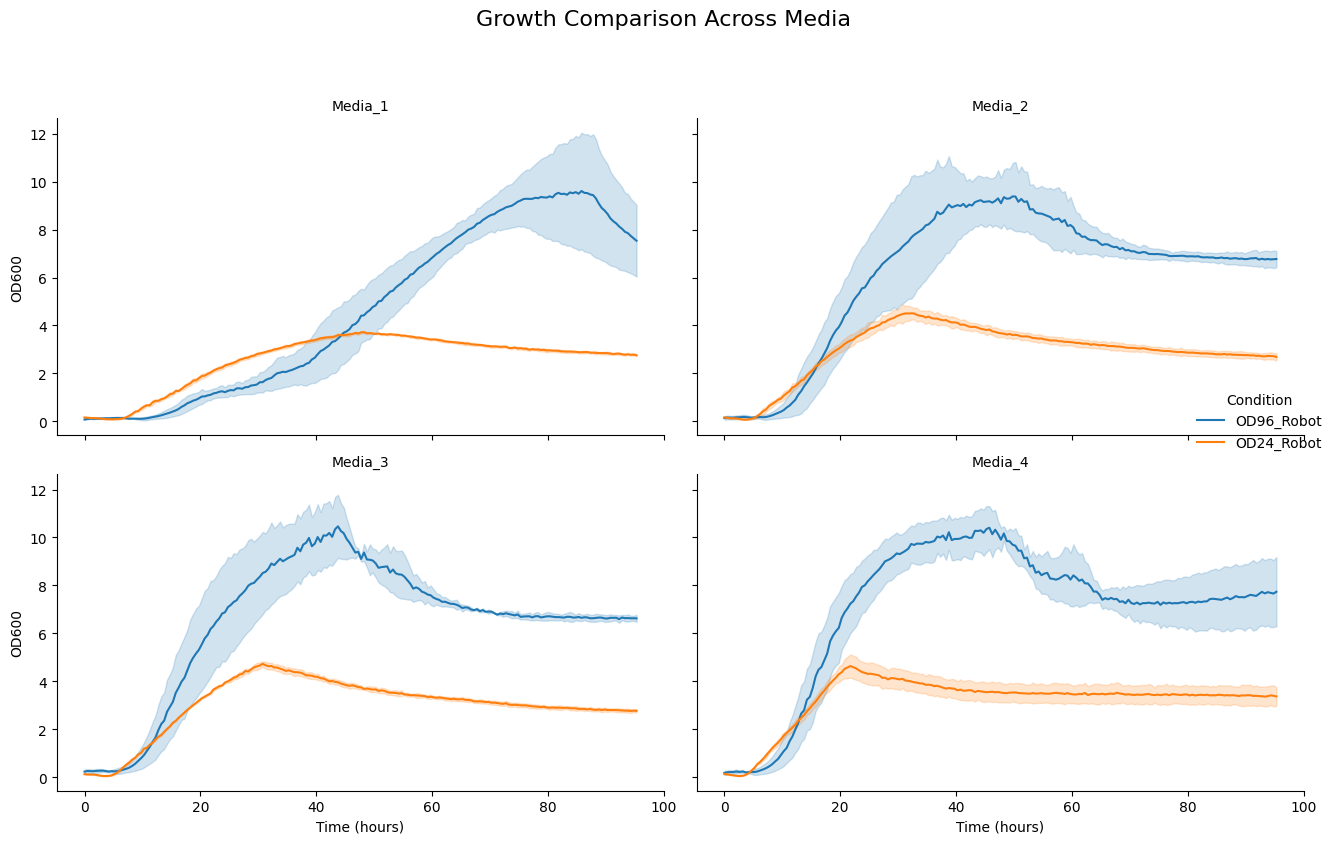

In [112]:
plot_growth_facets(df, condition_filter=['OD24_Robot', 'OD96_Robot'])
plot_growth_facets(df_3reps, condition_filter=['OD24_Robot','OD96_Robot'])
plot_growth_facets(df_3reps_low_sd, condition_filter=['OD24_Robot', 'OD96_Robot'])

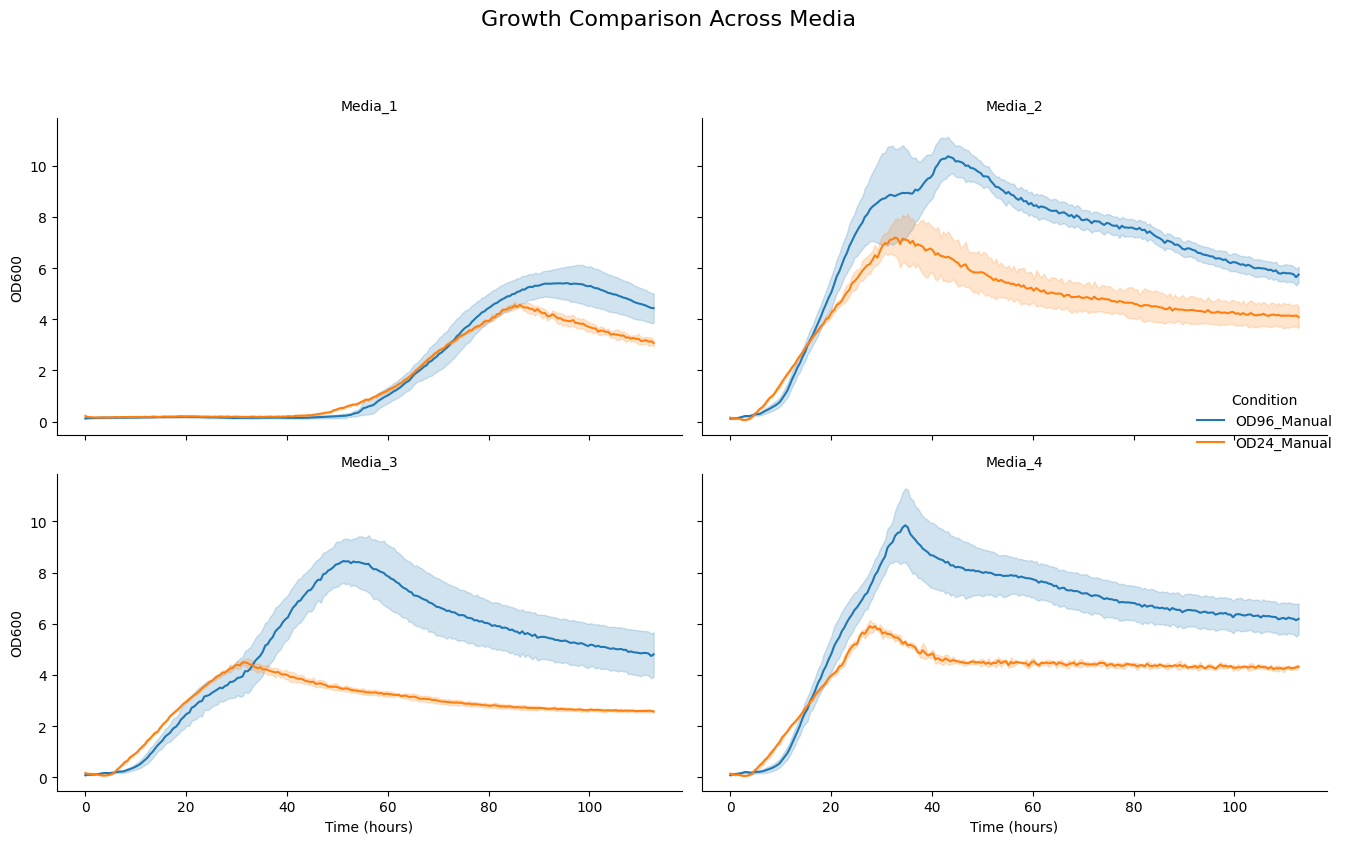

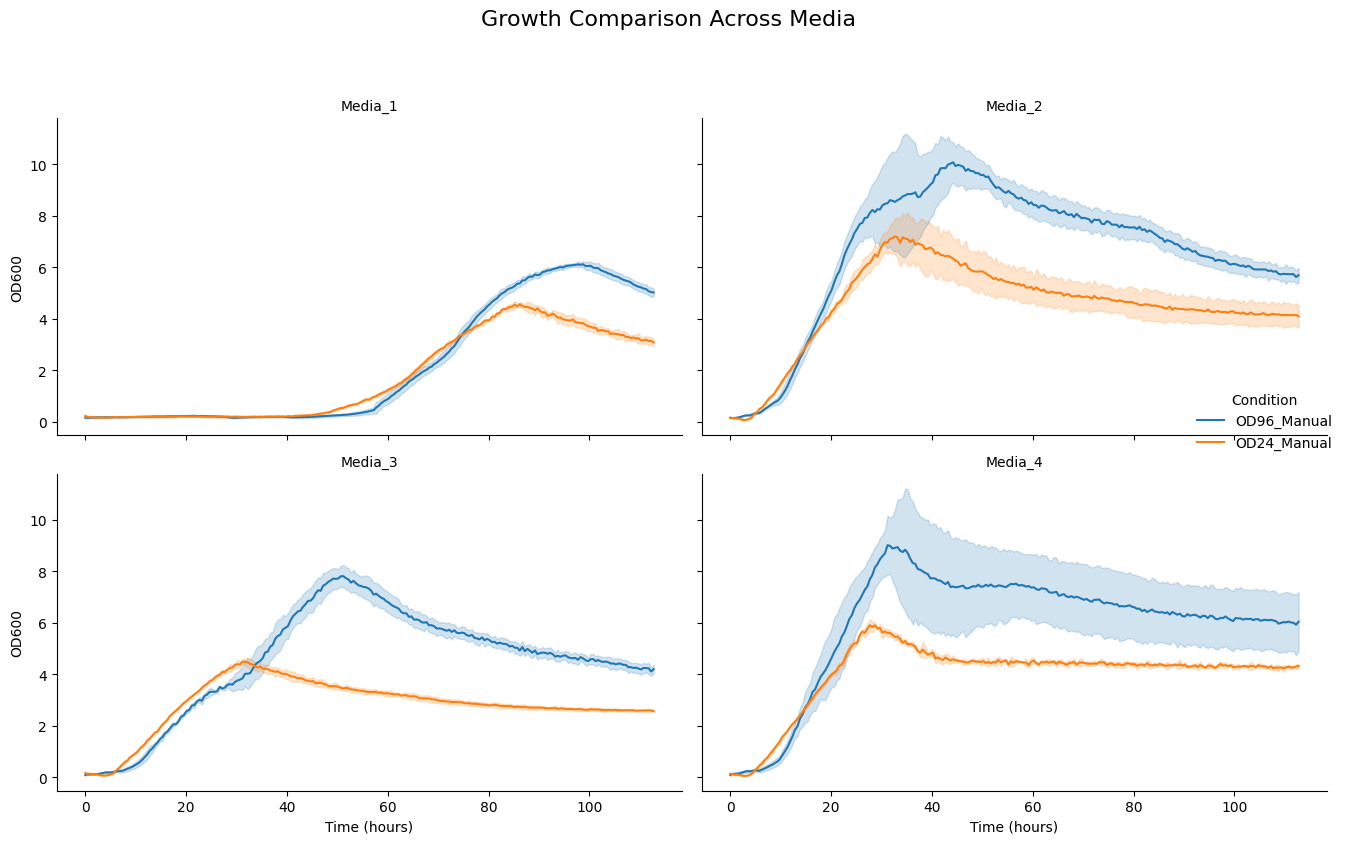

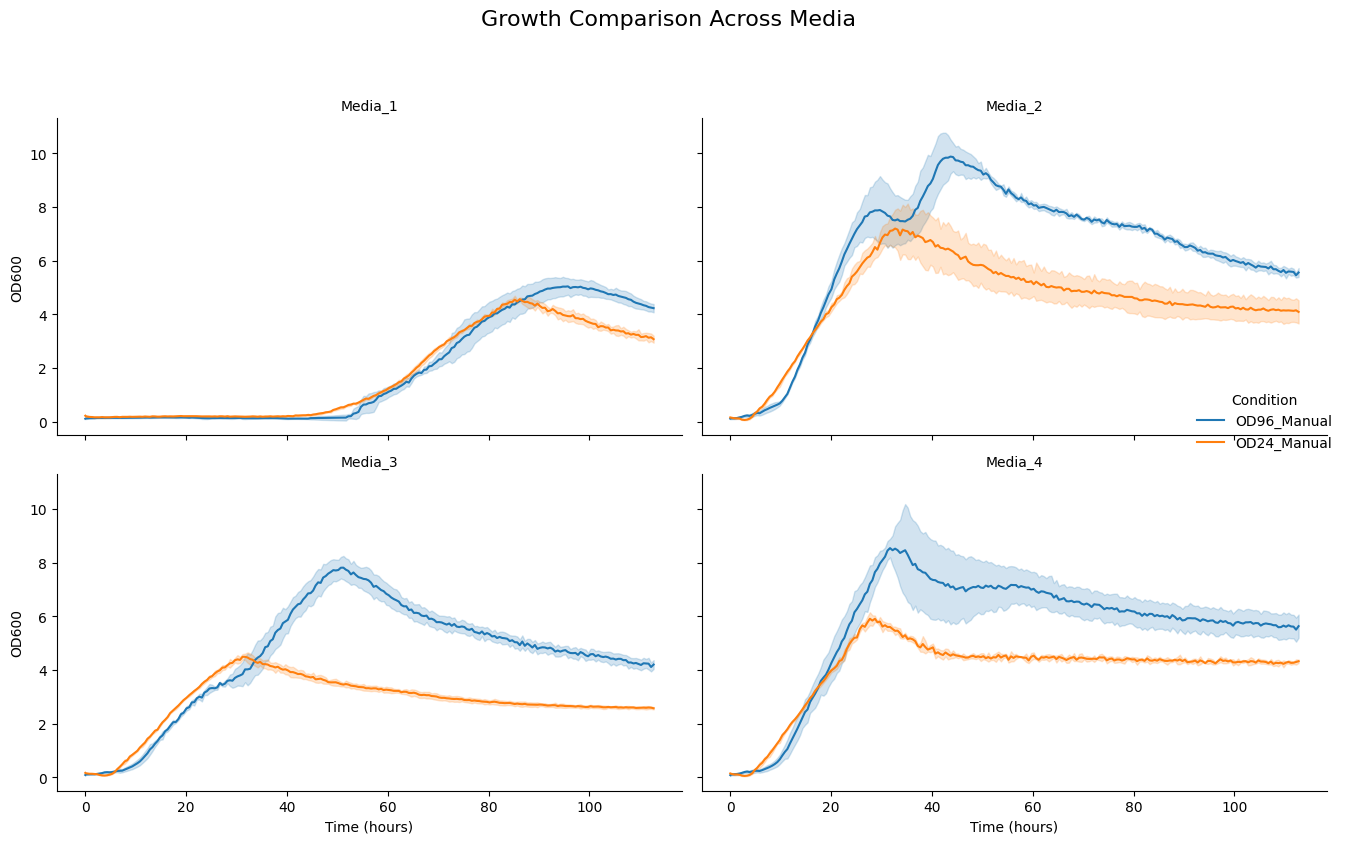

In [113]:
plot_growth_facets(df, condition_filter=['OD24_Manual', 'OD96_Manual'])
plot_growth_facets(df_3reps, condition_filter=['OD24_Manual','OD96_Manual'])
plot_growth_facets(df_3reps_low_sd, condition_filter=['OD24_Manual', 'OD96_Manual'])

In [ ]:
from scipy.stats import levene

# Subset for one condition (e.g., OD96_manual)
subset = df[df['Condition'] == 'OD96_Manual']
groups = [group['OD600'].values for name, group in subset.groupby('Media')]

stat, p = levene(*groups)
print(f"Levene’s test: stat={stat:.3f}, p={p:.4f}")


Levene’s test: stat=8.289, p=0.0000


In [44]:
# next step on the Leven'e test


from scipy.stats import levene

# Subset the data for the corrected condition name
subset = df[df['Condition'] == 'OD96_Manual']

# Group by media and prepare sample lists
groups = [
    group['OD600'].dropna().values
    for _, group in subset.groupby('Media')
    if len(group['OD600'].dropna()) > 1
]

# Run Levene's test if we have at least two groups
if len(groups) >= 2:
    stat, p = levene(*groups)
    print(f"Levene’s test: stat={stat:.3f}, p={p:.4f}")
    if p < 0.05:
        print("⚠️ Variances are significantly different across groups — consider Welch's ANOVA.")
    else:
        print("✅ Variances appear equal — standard ANOVA is appropriate.")
else:
    print("❌ Not enough valid groups for Levene’s test.")


Levene’s test: stat=8.289, p=0.0000
⚠️ Variances are significantly different across groups — consider Welch's ANOVA.


In [ ]:
# linear models or mixed models are more robust when n is unequal 

#This needs to be rewritten to consider time.

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

model = smf.ols('OD600 ~ Media + Condition + Media:Condition', data=df).fit()
anova_table = anova_lm(model, typ=2)
print(anova_table)

                       sum_sq       df            F  PR(>F)
Media            21938.040207      3.0  1251.622239     0.0
Condition        18431.430857      3.0  1051.561057     0.0
Media:Condition  10382.398412      9.0   197.447609     0.0
Residual         96764.505718  16562.0          NaN     NaN


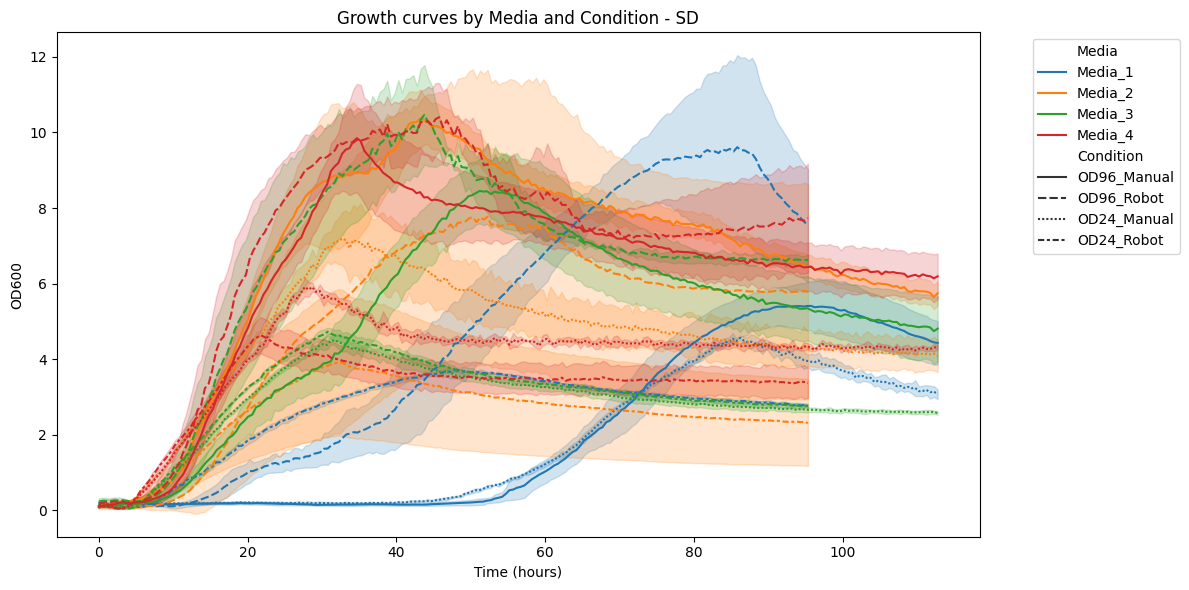

In [ ]:

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Time', y='OD600', hue='Media', style='Condition', errorbar = 'sd') #errorbar='sd' or errorbar=('ci',95)
plt.title('Growth curves by Media and Condition - SD')
plt.ylabel('OD600')
plt.xlabel('Time (hours)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [18]:
# Count unique replicates per Media and Condition
df.groupby(['Condition', 'Media'])['Replicate'].nunique()


Condition    Media  
OD24_Manual  Media_1    3
             Media_2    3
             Media_3    3
             Media_4    3
OD24_Robot   Media_1    3
             Media_2    6
             Media_3    3
             Media_4    3
OD96_Manual  Media_1    9
             Media_2    9
             Media_3    9
             Media_4    9
OD96_Robot   Media_1    3
             Media_2    6
             Media_3    3
             Media_4    3
Name: Replicate, dtype: int64

In [16]:
from scipy.stats import f_oneway

# Let's look at final OD600 (last time point) per condition
final_time = df['Time'].max()
subset = df[df['Time'] == final_time]

# Example: one-way ANOVA within a single condition
cond_df = subset[subset['Condition'] == 'OD96_Robot']

f_stat, p_val = f_oneway(
    *[group['OD600'].values for name, group in cond_df.groupby('Media')]
)

print(f"ANOVA for OD96_robot at final time:")
print(f"F = {f_stat:.3f}, p = {p_val:.4e}")


TypeError: At least two samples are required; got 0.

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Just use final OD600 for this example
model_df = subset.copy()

# Convert to categorical
model_df['Media'] = model_df['Media'].astype('category')
model_df['Condition'] = model_df['Condition'].astype('category')

# Fit model
model = smf.ols('OD600 ~ Media + Condition + Media:Condition', data=model_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                    sum_sq    df          F        PR(>F)
Media            23.242943   3.0  24.154370  4.386659e-09
Condition        28.480011   1.0  88.790397  1.042172e-11
Media:Condition   0.908447   3.0   0.944070  4.284464e-01
Residual         12.830221  40.0        NaN           NaN


In [42]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df['OD600'], groups=df['Media'] + "_" + df['Condition'], alpha=0.05)
print(tukey.summary())


             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1              group2       meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------
Media_1_OD24_Manual  Media_1_OD24_Robot   0.8366    0.0  0.3666  1.3066   True
Media_1_OD24_Manual Media_1_OD96_Manual   0.3047  0.245 -0.0626   0.672  False
Media_1_OD24_Manual  Media_1_OD96_Robot   2.8728    0.0  2.4028  3.3428   True
Media_1_OD24_Manual Media_2_OD24_Manual   2.7817    0.0  2.3318  3.2315   True
Media_1_OD24_Manual  Media_2_OD24_Robot   0.7878    0.0  0.3865  1.1891   True
Media_1_OD24_Manual Media_2_OD96_Manual   4.9287    0.0  4.5614   5.296   True
Media_1_OD24_Manual  Media_2_OD96_Robot   3.2841    0.0  2.8828  3.6854   True
Media_1_OD24_Manual Media_3_OD24_Manual   1.0846    0.0  0.6348  1.5344   True
Media_1_OD24_Manual  Media_3_OD24_Robot   1.2758    0.0  0.8058  1.7458   True
Media_1_OD24_Manual Media_3_OD96_Manual   3.2349    

In [15]:
import statsmodels.formula.api as smf

# Example: fit mixed model
# Assuming each unique replicate is identified (e.g., by combining Media + Replicate + Condition)

df['Subject'] = df['Media'] + "_" + df['Replicate'].astype(str) + "_" + df['Condition']

model = smf.mixedlm("OD600 ~ Time * Media * Condition", df, groups=df["Subject"])
result = model.fit()
print(result.summary())


                          Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            OD600      
No. Observations:            16578              Method:                        REML       
No. Groups:                  78                 Scale:                         3.3616     
Min. group size:             191                Log-Likelihood:                -33792.8555
Max. group size:             226                Converged:                     Yes        
Mean group size:             212.5                                                        
------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                      -0.794    0.529  -1.500 0.134 -1.830  0.243
Media[T.Media_2]          